In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
import codecs
from SmilesPE.pretokenizer import atomwise_tokenizer
from SmilesPE.tokenizer import *

In [3]:
from Levy.levenshteinaugment.levenshtein import Levenshtein_augment
from rdkit import Chem

#Supress warnings from RDKit
from rdkit import rdBase
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

In [4]:
df = pd.read_pickle('data/uspto50/uspto_50.pickle')
df.head()

,reactants_mol,products_mol,reaction_type,set
0,<rdkit.Chem.rdchem.Mol object at 0x7febb0490770>,<rdkit.Chem.rdchem.Mol object at 0x7febaec85530>,<RX_1>,train
1,<rdkit.Chem.rdchem.Mol object at 0x7febb0490810>,<rdkit.Chem.rdchem.Mol object at 0x7febaec85580>,<RX_6>,train
2,<rdkit.Chem.rdchem.Mol object at 0x7febb04908b0>,<rdkit.Chem.rdchem.Mol object at 0x7febaec855d0>,<RX_9>,train
3,<rdkit.Chem.rdchem.Mol object at 0x7febb0490950>,<rdkit.Chem.rdchem.Mol object at 0x7febaec85620>,<RX_6>,train
4,<rdkit.Chem.rdchem.Mol object at 0x7febb04909f0>,<rdkit.Chem.rdchem.Mol object at 0x7febaec85670>,<RX_1>,train


In [14]:
from rdkit.Chem import rdFMCS

df_new = {
    'reactants_mol': [],
    'products_mol': [],
    'reaction_type': [],
    'set': [],
    'importance': [],
}

for row in tqdm(df.itertuples(), total=len(df)):
    product = row.products_mol
    reactants = row.reactants_mol
    reactants = Chem.MolToSmiles(reactants)
    reactants = reactants.split('.')
    reactants = [Chem.MolFromSmiles(reactant) for reactant in reactants]

    # find overlap between reactant and product
    sorted_reactants = []
    for reactant in reactants:
        overlap = rdFMCS.FindMCS([reactant, product])
        sorted_reactants.append((reactant, overlap.numAtoms, overlap.numBonds))
    sorted_reactants = sorted(sorted_reactants, key=lambda x: x[1], reverse=True)

    for i, (reactant, _, _) in enumerate(sorted_reactants):
        df_new['reactants_mol'].append(reactant)
        df_new['products_mol'].append(product)
        df_new['reaction_type'].append(row.reaction_type)
        df_new['set'].append(row.set)
        df_new['importance'].append(i)

  0%|          | 0/50037 [00:00<?, ?it/s]

100%|██████████| 50037/50037 [5:09:18<00:00,  2.70it/s]    


In [23]:
sike_df = pd.DataFrame(df_new)

In [24]:
sike_df

,reactants_mol,products_mol,reaction_type,set,importance
0,<rdkit.Chem.rdchem.Mol object at 0x7fce9eee2a40>,<rdkit.Chem.rdchem.Mol object at 0x7fcea0c1de40>,<RX_1>,train,0
1,<rdkit.Chem.rdchem.Mol object at 0x7fce9eee2340>,<rdkit.Chem.rdchem.Mol object at 0x7fcea0c1de40>,<RX_1>,train,1
2,<rdkit.Chem.rdchem.Mol object at 0x7fce9eee2730>,<rdkit.Chem.rdchem.Mol object at 0x7fcea0c1de90>,<RX_6>,train,0
3,<rdkit.Chem.rdchem.Mol object at 0x7fce9eee1a80>,<rdkit.Chem.rdchem.Mol object at 0x7fcea0c1dee0>,<RX_9>,train,0
4,<rdkit.Chem.rdchem.Mol object at 0x7fce9eee1700>,<rdkit.Chem.rdchem.Mol object at 0x7fcea0c1dee0>,<RX_9>,train,1
...,...,...,...,...,...
85533,<rdkit.Chem.rdchem.Mol object at 0x7fcea0d3a9d0>,<rdkit.Chem.rdchem.Mol object at 0x7fce9f116f20>,<RX_7>,test,0
85534,<rdkit.Chem.rdchem.Mol object at 0x7fcea0d3a8f0>,<rdkit.Chem.rdchem.Mol object at 0x7fce9f116f70>,<RX_10>,test,0
85535,<rdkit.Chem.rdchem.Mol object at 0x7fcea0d3aa40>,<rdkit.Chem.rdchem.Mol object at 0x7fce9f116f70>,<RX_10>,test,1
85536,<rdkit.Chem.rdchem.Mol object at 0x7fcea0d3aab0>,<rdkit.Chem.rdchem.Mol object at 0x7fce9f116fc0>,<RX_1>,test,0


In [25]:
type(sike_df['reactants_mol'][0])

rdkit.Chem.rdchem.Mol

In [28]:
sike_df.to_pickle('data/uspto50/uspto_50_sike.pickle')

In [8]:
sike_df = pd.read_pickle('data/uspto50/uspto_50_sike.pickle')
sike_df

,reactants_mol,products_mol,reaction_type,set,importance,IFT
0,<rdkit.Chem.rdchem.Mol object at 0x7f6b3af9ae80>,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d620>,<RX_1>,train,0,<IFT_1>
1,<rdkit.Chem.rdchem.Mol object at 0x7f6b3af9b600>,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d620>,<RX_1>,train,1,<IFT_2>
2,<rdkit.Chem.rdchem.Mol object at 0x7f6b3af9bbf0>,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d670>,<RX_6>,train,0,<IFT_1>
3,<rdkit.Chem.rdchem.Mol object at 0x7f6b3af9bfb0>,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d6c0>,<RX_9>,train,0,<IFT_1>
4,<rdkit.Chem.rdchem.Mol object at 0x7f6b3af9b060>,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d6c0>,<RX_9>,train,1,<IFT_2>
...,...,...,...,...,...,...
85533,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d490>,<rdkit.Chem.rdchem.Mol object at 0x7f6b38e52700>,<RX_7>,test,0,<IFT_1>
85534,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d4e0>,<rdkit.Chem.rdchem.Mol object at 0x7f6b38e52750>,<RX_10>,test,0,<IFT_1>
85535,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d530>,<rdkit.Chem.rdchem.Mol object at 0x7f6b38e52750>,<RX_10>,test,1,<IFT_2>
85536,<rdkit.Chem.rdchem.Mol object at 0x7f6b3c40d580>,<rdkit.Chem.rdchem.Mol object at 0x7f6b38e527a0>,<RX_1>,test,0,<IFT_1>


In [7]:
sike_df['IFT'] = sike_df['importance'].apply(lambda x: f'<IFT_{x+1}>')
# sike_df.to_pickle('data/uspto50/uspto_50_sike.pickle')

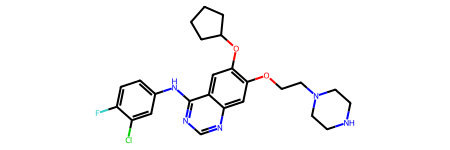

In [9]:
sike_df.iloc[0]['reactants_mol']

In [65]:
df = pd.read_pickle('data/uspto50/processed.pickle')
df.head()

,reactants_mol,products_mol,reaction_type,set,num_reacts,num_prods,ratio
0,"[CS(=O)(=O)OC[C@H]1CCC(=O)O1, Fc1ccc(Nc2ncnc3c...",[O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl...,<RX_1>,train,2,1,1.121951
1,[COC(=O)c1cc(CCCc2cc3c(=O)[nH]c(N)nc3[nH]2)cs1],[Nc1nc2[nH]c(CCCc3csc(C(=O)O)c3)cc2c(=O)[nH]1],<RX_6>,train,1,1,1.045455
2,"[CC1(C)OB(B2OC(C)(C)C(C)(C)O2)OC1(C)C, FC(F)(F...",[CC1(C)OB(c2cccc(Nc3nccc(C(F)(F)F)n3)c2)OC1(C)C],<RX_9>,train,2,1,1.384615
3,[CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)OCc1ccccc1],[CC(C)(C)OC(=O)NCC(=O)CCC(=O)OCCCC(=O)O],<RX_6>,train,1,1,1.318182
4,"[Fc1cc2c(Cl)ncnc2cn1, NC1CCCCCC1]",[Fc1cc2c(NC3CCCCCC3)ncnc2cn1],<RX_1>,train,2,1,1.052632


In [66]:
augmenter = Levenshtein_augment(source_augmentation=1, randomization_tries=1000)

In [67]:
def augment(reactants, products):
    # reactants = sorted(reactants, key=lambda x: len(x), reverse=True)
    # products  = sorted(products, key=lambda x: len(x), reverse=True)
    
    new_reactants, new_products, all_score = [], [], []
    reactant, product = '.'.join(reactants), '.'.join(products)

    pairs = augmenter.levenshtein_pairing(reactant, product)
    augmentations = augmenter.sample_pairs(pairs)

    for new_reactant, new_product, score in augmentations:
        new_reactants.append(new_reactant)
        new_products.append(new_product)
        all_score.append(score)
    
    return new_reactants, new_products, all_score

In [68]:
with open('Chemformer/my_vocab.txt') as f:
    char2idx = f.read().split('\n')
char2idx = {c: i for i, c in enumerate(char2idx)}
idx2char = {i: c for i, c in enumerate(char2idx)}

In [69]:
for i, (reactants, products) in enumerate(tqdm(zip(df['reactants_mol'], df['products_mol']), total=len(df))):
    new_products, new_reactants, score = augment(products, reactants)
    print(f'{".".join(reactants)} -> {".".join(products)}')
    for reactant, product, sc in zip(new_reactants, new_products, score):
        print(f'{sc:.2f}: {reactant} -> {product}')
        reactant = [char2idx['^']] + [char2idx[char] for char in atomwise_tokenizer(reactant)] + [char2idx['&']]
        product  = [char2idx['^']] + [char2idx[char] for char in atomwise_tokenizer(product)] + [char2idx['&']]
    break

  0%|          | 0/50037 [00:00<?, ?it/s]

CS(=O)(=O)OC[C@H]1CCC(=O)O1.Fc1ccc(Nc2ncnc3cc(OCCN4CCNCC4)c(OC4CCCC4)cc23)cc1Cl -> O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)c5)c4cc3OC3CCCC3)CC2)O1
0.71: O(S(=O)(C)=O)C[C@H]1CCC(=O)O1.N1CCN(CCOc2cc3ncnc(Nc4ccc(F)c(Cl)c4)c3cc2OC2CCCC2)CC1 -> O=C1CC[C@H](CN2CCN(CCOc3cc4ncnc(Nc5ccc(F)c(Cl)c5)c4cc3OC3CCCC3)CC2)O1


In [59]:
%%timeit
augment(df['products_mol'].iloc[0], df['reactants_mol'].iloc[0])

553 ms ± 45.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [77]:
class LevySMILES(Dataset):
    def __init__(self, split: str='val') -> None:

        self.split = 'valid' if split == 'val' else split
        
        self.df = pd.read_pickle('data/uspto50/processed.pickle')
        self.df = self.df[self.df['set'] == self.split]

        self.augmenter = Levenshtein_augment(source_augmentation=1, randomization_tries=1000)

        with open('Chemformer/my_vocab.txt') as f:
            char2idx = f.read().split('\n')
        self.char2idx = {c: i for i, c in enumerate(char2idx)}
        self.idx2char = {i: c for i, c in enumerate(char2idx)}
        
        self.start_token = self.char2idx['^']
        self.end_token   = self.char2idx['&']
        self.pad_token   = self.char2idx['<PAD>']

    def augment(self, reactants, products):
        new_reactants, new_products, all_score = [], [], []
        reactant, product = '.'.join(reactants), '.'.join(products)

        pairs = self.augmenter.levenshtein_pairing(reactant, product)
        augmentations = self.augmenter.sample_pairs(pairs)

        for new_reactant, new_product, score in augmentations:
            new_reactants.append(new_reactant)
            new_products.append(new_product)
            all_score.append(score)
        
        return new_reactants, new_products, all_score

    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int) -> dict:
        # get reactants and products
        reactants, products = self.df['reactants_mol'].iloc[idx], self.df['products_mol'].iloc[idx]
        
        # augment and find best pair
        new_products, new_reactants, score = self.augment(products, reactants)
        new_reactants, new_products = new_reactants[0], new_products[0]
        
        # tokenize
        new_reactants = [self.start_token] + [self.char2idx[char] for char in atomwise_tokenizer(new_reactants)] + [self.end_token]
        new_products  = [self.start_token] + [self.char2idx[char] for char in atomwise_tokenizer(new_products)]  + [self.end_token]

        # convert to tensor
        new_reactants = torch.tensor(new_reactants).long()
        new_products  = torch.tensor(new_products).long()
        
        return {'encoder_output': new_reactants, 'encoder_input': new_products}

    def collate_fn(self, batch):
        # extract batch elements
        encoder_input = [x['encoder_input'] for x in batch]
        encoder_output = [x['encoder_output'] for x in batch]
        
        # pad to maximum length
        encoder_input = torch.nn.utils.rnn.pad_sequence(encoder_input, batch_first=True, padding_value=self.pad_token)
        encoder_output = torch.nn.utils.rnn.pad_sequence(encoder_output, batch_first=True, padding_value=self.pad_token)
        
        return {'encoder_input': encoder_input, 'encoder_output': encoder_output}

In [82]:
val_dataset = LevySMILES(split='val')
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=16, collate_fn=val_dataset.collate_fn)

In [83]:
for batch in tqdm(val_loader):
    pass

100%|██████████| 40/40 [01:57<00:00,  2.95s/it]


In [84]:
char2idx

{'<PAD>': 0,
 '?': 1,
 '^': 2,
 '&': 3,
 '<MASK>': 4,
 '<SEP>': 5,
 'LogD_change_(-0.1, 0.1]': 6,
 'LogD_change_(0.1, 0.3]': 7,
 'LogD_change_(0.3, 0.5]': 8,
 'LogD_change_(0.5, 0.7]': 9,
 'LogD_change_(0.7, 0.9]': 10,
 'LogD_change_(0.9, 1.1]': 11,
 'LogD_change_(1.1, 1.3]': 12,
 'LogD_change_(1.3, 1.5]': 13,
 'LogD_change_(1.5, 1.7]': 14,
 'LogD_change_(1.7, 1.9]': 15,
 'LogD_change_(1.9, 2.1]': 16,
 'LogD_change_(2.1, 2.3]': 17,
 'LogD_change_(2.3, 2.5]': 18,
 'LogD_change_(2.5, 2.7]': 19,
 'LogD_change_(2.7, 2.9]': 20,
 'LogD_change_(2.9, 3.1]': 21,
 'LogD_change_(3.1, 3.3]': 22,
 'LogD_change_(3.3, 3.5]': 23,
 'LogD_change_(3.5, 3.7]': 24,
 'LogD_change_(3.7, 3.9]': 25,
 'LogD_change_(3.9, 4.1]': 26,
 'LogD_change_(4.1, 4.3]': 27,
 'LogD_change_(4.3, 4.5]': 28,
 'LogD_change_(4.5, 4.7]': 29,
 'LogD_change_(4.7, 4.9]': 30,
 'LogD_change_(4.9, 5.1]': 31,
 'LogD_change_(5.1, 5.3]': 32,
 'LogD_change_(5.3, 5.5]': 33,
 'LogD_change_(5.5, 5.7]': 34,
 'LogD_change_(5.7, 5.9]': 35,
 'LogD

In [4]:
df = pd.read_pickle('data/uspto50/uspto_50_sike.pickle')
df

,reactants_mol,products_mol,reaction_type,set,importance,IFT
0,<rdkit.Chem.rdchem.Mol object at 0x7fcfe188d1c0>,<rdkit.Chem.rdchem.Mol object at 0x7fcfde061fd0>,<RX_1>,train,0,<IFT_1>
1,<rdkit.Chem.rdchem.Mol object at 0x7fcfe188d260>,<rdkit.Chem.rdchem.Mol object at 0x7fcfde061fd0>,<RX_1>,train,1,<IFT_2>
2,<rdkit.Chem.rdchem.Mol object at 0x7fcfe188d300>,<rdkit.Chem.rdchem.Mol object at 0x7fcfde062020>,<RX_6>,train,0,<IFT_1>
3,<rdkit.Chem.rdchem.Mol object at 0x7fcfe188d3a0>,<rdkit.Chem.rdchem.Mol object at 0x7fcfde062070>,<RX_9>,train,0,<IFT_1>
4,<rdkit.Chem.rdchem.Mol object at 0x7fcfe188d440>,<rdkit.Chem.rdchem.Mol object at 0x7fcfde062070>,<RX_9>,train,1,<IFT_2>
...,...,...,...,...,...,...
85533,<rdkit.Chem.rdchem.Mol object at 0x7fcfde061e40>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdbc4b0b0>,<RX_7>,test,0,<IFT_1>
85534,<rdkit.Chem.rdchem.Mol object at 0x7fcfde061e90>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdbc4b100>,<RX_10>,test,0,<IFT_1>
85535,<rdkit.Chem.rdchem.Mol object at 0x7fcfde061ee0>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdbc4b100>,<RX_10>,test,1,<IFT_2>
85536,<rdkit.Chem.rdchem.Mol object at 0x7fcfde061f30>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdbc4b150>,<RX_1>,test,0,<IFT_1>


In [10]:
single_df = df[df['importance'] == 0]
single_df = single_df.reset_index(drop=True)
single_df.to_pickle('data/uspto50/uspto_50_sike_single.pickle')

In [11]:
single_df = pd.read_pickle('data/uspto50/uspto_50_sike_single.pickle')
single_df

,reactants_mol,products_mol,reaction_type,set,importance,IFT
0,<rdkit.Chem.rdchem.Mol object at 0x7fcfdae78590>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0cc0>,<RX_1>,train,0,<IFT_1>
1,<rdkit.Chem.rdchem.Mol object at 0x7fcfdae7a390>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0d10>,<RX_6>,train,0,<IFT_1>
2,<rdkit.Chem.rdchem.Mol object at 0x7fcfdae79c10>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0d60>,<RX_9>,train,0,<IFT_1>
3,<rdkit.Chem.rdchem.Mol object at 0x7fcfdae7bc40>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0db0>,<RX_6>,train,0,<IFT_1>
4,<rdkit.Chem.rdchem.Mol object at 0x7fcfdae7b8d0>,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0e00>,<RX_1>,train,0,<IFT_1>
...,...,...,...,...,...,...
50032,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0b30>,<rdkit.Chem.rdchem.Mol object at 0x7fcfd9571d00>,<RX_1>,test,0,<IFT_1>
50033,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0b80>,<rdkit.Chem.rdchem.Mol object at 0x7fcfd9571d50>,<RX_6>,test,0,<IFT_1>
50034,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0bd0>,<rdkit.Chem.rdchem.Mol object at 0x7fcfd9571da0>,<RX_7>,test,0,<IFT_1>
50035,<rdkit.Chem.rdchem.Mol object at 0x7fcfdfda0c20>,<rdkit.Chem.rdchem.Mol object at 0x7fcfd9571df0>,<RX_10>,test,0,<IFT_1>
